In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import tree
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [10]:
def to_recall_bin(acc):
    bins = [
        [0.0, 0.75],
        [0.75, 1.0]
    ]
    return [i for i, b in enumerate(bins) if b[0] <= acc and b[1] >= acc][0]


df['recall_bin'] = [to_recall_bin(a) for a in df['recall']]

In [47]:
from sklearn.decomposition import TruncatedSVD

accuracies = {}

test_split = 0.33
# filtered = df.loc[df.accuracy_negative >= 0.95]
filtered = df
filtered = filtered.loc[filtered.type_of_transfer != 'No transfer']
# filtered = filtered.loc[filtered.type_of_transfer != 'Across spaces']

msk = np.random.rand(len(filtered)) <= test_split
train = filtered[msk]
test = filtered[~msk]

x_columns = [
    'features',
    'classifier',
    'label',
    'samples',
    'type_of_transfer',
    'source_device_type',
    'target_device_type',
    'f1_wt',
    'specificity'
]

def to_x_and_y(filtered, columns=x_columns):

    X = filtered[columns]

    y = filtered['recall_bin']

    X = [dict(r.iteritems()) for _, r in X.iterrows()]
    y = y.values

    return X, y

X_train, y_train = to_x_and_y(train)
X_test, y_test = to_x_and_y(test)

ppl = Pipeline([
    ('vect', DictVectorizer()),
    ('impute', Imputer()),
    ('clf', RandomForestClassifier())
])

ppl.fit(X_train, y_train)
predicted = ppl.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(accuracy)

0.979349384126


In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('Precision', np.round(precision_score(y_test, predicted, pos_label=1, average='binary'), 2))
print('Recall', np.round(recall_score(y_test, predicted, pos_label=1, average='binary'), 2))
print('F1', np.round(f1_score(y_test, predicted, pos_label=1, average='binary'), 2))

mask_negative = y_test == 0
print('Specificity', np.round(accuracy_score(y_test[mask_negative], predicted[mask_negative]), 2))
print('Accuracy', np.round(accuracy_score(y_test, predicted), 2))

Precision 0.71
Recall 0.43
F1 0.54
Specificity 0.99
Accuracy 0.98


In [15]:
predictions = pd.Series(predicted)
predictions.index = test.index
df['predictions'] = predictions

df_tested = df.loc[df.predictions >= 0]
counts = df_tested[['recall_bin', 'predictions']].groupby(['recall_bin', 'predictions']).size()
counts = pd.DataFrame(counts)
counts.columns = ['count']
counts.pivot_table(index=['recall_bin'], columns=['predictions'], values=['count'])

count     
predictions     0.0  1.0
recall_bin              
0            159967  349
1              3699  920

In [5]:
df_tested.to_pickle('results_with_accuracy_classified.p')

In [6]:
df_tested

,source_dataset,target_dataset,source_device,target_device,source_device_name,target_device_name,source_room,target_room,source_placement,target_placement,...,classifier,label,features,features_name,accuracy,accuracy_positive,accuracy_negative,accuracy_bin,accuracy_without_transfer,predictions
1,synergy-final-iter4,synergy-final-iter1,128.237.247.190,128.237.254.195,Mite 1 Table,Mite 3 Sink,synergy,synergy,Table,Sink,...,SVM,Kettle,.*,All,0.755102,0.324251,0.832842,0,0.443850,0.0
3,synergy-final-iter4,synergy-final-iter2,128.237.247.190,128.237.248.186,Mite 1 Table,Mite 2 Sink,synergy,synergy,Table,Sink,...,SVM,Kettle,.*,All,0.795918,0.469169,0.849538,0,0.443850,0.0
5,synergy-final-iter4,synergy-final-iter4,128.237.247.190,128.237.250.218,Mite 1 Table,Mite 4 Coffee,synergy,synergy,Table,Coffee,...,SVM,Kettle,.*,All,0.771228,0.730769,0.776916,0,0.443850,0.0
6,synergy-final-iter4,synergy-final-iter5,128.237.247.190,128.237.227.76,Mite 1 Table,Mite 2 Coffee,synergy,synergy,Table,Coffee,...,SVM,Kettle,.*,All,0.657570,0.845946,0.635166,1,0.443850,0.0
7,synergy-final-iter4,synergy-final-iter5,128.237.247.190,128.237.250.218,Mite 1 Table,Mite 4 Sink,synergy,synergy,Table,Sink,...,SVM,Kettle,.*,All,0.691145,0.756757,0.682885,1,0.443850,0.0
14,synergy-final-iter4,synergy-final-iter1,128.237.247.190,128.237.248.186,Mite 1 Table,Mite 2 Table,synergy,synergy,Table,Table,...,RandomForestClassifier,Kettle,.*,All,0.849263,0.013263,0.988106,0,0.873684,0.0
16,synergy-final-iter4,synergy-final-iter2,128.237.247.190,128.237.254.195,Mite 1 Table,Mite 3 Coffee,synergy,synergy,Table,Coffee,...,RandomForestClassifier,Kettle,.*,All,0.831833,0.006231,0.979888,0,0.873684,0.0
17,synergy-final-iter4,synergy-final-iter4,128.237.247.190,128.237.250.218,Mite 1 Table,Mite 4 Coffee,synergy,synergy,Table,Coffee,...,RandomForestClassifier,Kettle,.*,All,0.772671,0.379599,0.827927,0,0.873684,0.0
19,synergy-final-iter4,synergy-final-iter5,128.237.247.190,128.237.250.218,Mite 1 Table,Mite 4 Sink,synergy,synergy,Table,Sink,...,RandomForestClassifier,Kettle,.*,All,0.844666,0.000000,0.951004,0,0.873684,0.0
25,synergy-final-iter4,synergy-final-iter1,128.237.247.190,128.237.254.195,Mite 1 Table,Mite 3 Sink,synergy,synergy,Table,Sink,...,LogisticRegression,Kettle,.*,All,0.710537,0.351499,0.775320,0,0.423280,0.0


In [57]:
filtered_x, filtered_y = to_x_and_y(filtered, columns=[
    'features',
    'classifier',
    'label',
    'samples',
    'type_of_transfer',
    'source_device_type',
    'target_device_type',
    'f1_wt',
    'specificity'
])

filtered_x = DictVectorizer().fit_transform(filtered_x)
filtered_x = pd.DataFrame(filtered_x.toarray())

filtered_y_s = pd.Series(filtered_y, index=filtered_x.index)
filtered_x_s = filtered_x.sample(10000)
filtered_y_s = filtered_y_s[filtered_x_s.index]

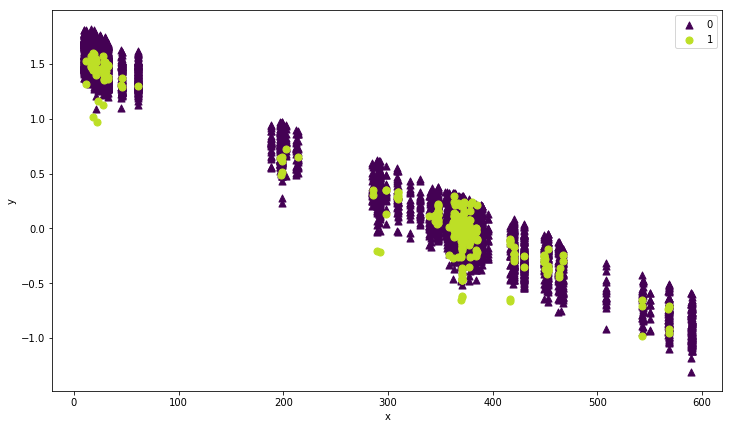

In [58]:
from sklearn.decomposition import TruncatedSVD

def plot_2d(transformed, y, title=''):
    df = pd.DataFrame(transformed, columns=['x', 'y'])
    df['label'] = y

    fig, ax = plt.subplots()

    labels = df.label.unique()

    colormap = cm.viridis
    colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(labels))]
    markers = ['^', 'o', 'v', 's', 'd']

    for i, label in enumerate(labels):
        c = colorlist[i]
        subdf = df.loc[df.label == label]
        if len(subdf):
            subdf.plot.scatter('x', 'y',
                               marker=markers[i % len(markers)], s=50,
                               label=label, ax=ax, c=c)

    plt.title(title)

    ax.legend()
#     plt.savefig('plots/tsne.pdf')
    plt.show()

plot_2d(TruncatedSVD(n_components=2).fit_transform(filtered_x_s), filtered_y_s.values)

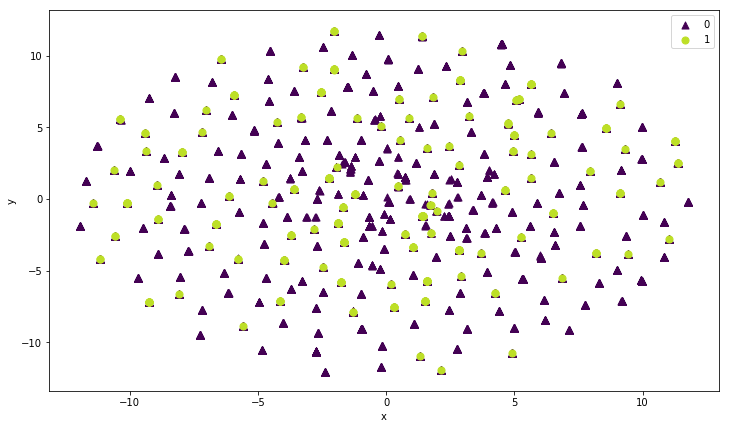

In [49]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.colors as colors

def plot_tsne(df, y, title=''):
    X = df.values
    # calculate tsne
    model = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    transformed = model.fit_transform(X)

    plot_2d(transformed, y, title)

plot_tsne(filtered_x_s, filtered_y_s.values)

In [60]:
df_tested.source_placement.unique()

array(['Coffee', 'Sink', 'Entrance', 'Pantry', 'Right', 'Left', 'Table'], dtype=object)